# Simulación de la respuesta óptica de sistemas opticos multicapas 1D

Los sistemas opticos multicapas son utiles como guias de onda, por medio del fenomeno de interferencia, este sistema fovorece la la transmisión y/o reflexión de ciertas longitudes de ondas variando los parametros de indice de refracción y/o el grosor de la capas.

Tanto en la naturaleza (para la generación de color y refrigeramiento, etc.) como en la tecnología (para circuitos opticos por ej.) estos sistemas se encuentran ampliamente y es de gran importancia tener un metodo para predecir la respuesta optica de dichos sistemas.


In [1]:
#@title Librerias

import cmath
import numpy as np
import matplotlib.pylab as plt
import sympy as sp
from IPython.display import display, Image

Para calcular la reflección y transmisión de multiples capas, primero hay que computar algunas funciones basicas que describen los fenomenos mas fundamentales, como:
- **SNELL()** que calcula el cambio de ángulo por refracción.
- **PATH()** que calcula el la distancia que recorre un rayo en un medio concreto dependiendo al ángulo en que incide,
- **CAUCHY()** algunos indices de refracción siguen la distribucion de cauchy, la cual depende de dos indices caracteristicos de cada material A & B y cada longitud de onda.

In [2]:
#@title Funciones Básicas

def CAUCHY(INDICES_,ESPECTRO_):
  N = np.zeros( (np.shape(INDICES_)[0],np.shape(ESPECTRO_)[0]), dtype=complex )

  for i in range(np.shape(INDICES_)[0]):
    N[i,:] = INDICES_[i,0] + (INDICES_[i,1] / ESPECTRO_[:]**2)
  return N

def SNELL(theta_1,N_):
  THETA = np.array( np.zeros( (np.shape(N_)[0],np.shape(N_)[1]) ), dtype=complex )
  THETA[0,:] = np.array([theta_1]*np.shape(N_)[1])

  for i in range(np.shape(N_)[0] - 1):
      THETA[i + 1,:] = ( np.arcsin( ( np.sin(THETA[i,:]) * N_[i,:]) / N_[i + 1,:]) )
  return THETA[:,:]

def PATH(GROSOR_,THETA_):
  CAMINO = GROSOR_[:,:] / np.cos(THETA_[1:-1,:])
  return np.array(CAMINO)

El lugar donde dos medios se solapan la conocemos como interfaz, cuando una onda cambia de medio, se produce el fenomeno de refracción y reflexión, para calcular la relación entre la amplitud de la onda incidente con la transmitidad (transmitancia) y con la reflejada (reflectancia), se aplican las ecuaciones de Fresel para cada interfaz, dependiendo a a la polarizacion "TE" o "TM" y del lado al cual se esta aproximando a la interfaz.

In [3]:
#@title Ecuaciones de Fresnel

def TE(ij_,THETA_,N_):

  if  ij_ != "12" and ij_ != "21":
    raise Exception("sub_index not valid")

  R_TE, T_TE = np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex ), np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex )

  if ij_ == '12':
    for i in range(np.shape(N_)[0] - 1):
      R_TE[i,:] = ( ( N_[i,:] * np.cos(THETA_[i,:]) ) - (N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) ) / ( ( N_[i,:] * np.cos(THETA_[i,:]) ) + ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) )
      T_TE[i,:] = 1 + R_TE[i,:]

  if ij_ == '21':
    for i in range(np.shape(N_)[0] - 1):
      R_TE[i,:] = ( ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) - (N_[i,:] * np.cos(THETA_[i,:]) ) ) / ( ( N_[i + 1,:] * np.cos(THETA_[i + 1,:]) ) + ( N_[i,:] * np.cos(THETA_[i,:]) ) )
      T_TE[i,:] = 1 + R_TE[i,:]

  return np.array( ( T_TE, R_TE ) )

def TM(ij_,THETA_,N_):

  if  ij_ != "12" and ij_ != "21":
    raise Exception("sub_index not valid")

  R_TM, T_TM = np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex ), np.zeros( ( np.shape(N_)[0] - 1, np.shape(N_)[1] ), dtype=complex )

  if ij_ == '12':
    for i in range(np.shape(N_)[0] - 1):
      R_TM[i,:] = ( ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) - ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) ) / ( ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) + ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) )
      T_TM[i,:] = ( (1 + R_TM[i,:]) * np.cos(THETA_[i]) ) / np.cos(THETA_[i + 1])

  if ij_ == '21':
    for i in range(np.shape(N_)[0] - 1):
      R_TM[i,:] = ( ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) - ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) ) / ( ( N_[i + 1,:] * (np.cos(THETA_[i + 1,:])**(-1)) ) + ( N_[i,:] * (np.cos(THETA_[i,:])**(-1)) ) )
      T_TM[i,:] = ( (1 + R_TM[i,:]) * np.cos(THETA_[i + 1]) ) / np.cos(THETA_[i])

  return np.array( ( T_TM, R_TM ) )

Para un tratamiento matematico mas comodo, se utiliza el método de las matrices, donde primero se calcula la matriz de scattering S (Cuyas entradas son las transmitancias y reflecatancias de ambos lados de la interfaz) y la matriz de propagación P que calcula el cambio de fase que cierta onda sufre al propagarse en un medio (a su vez calcula el amortiguamiento de la onda en el medio cuando el indice de refracción es complejo)

![Matriz S](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20S.png?raw=true)
![Matriz de scattering S](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20de%20scattering%20S.png?raw=true)

In [4]:
#@title Matriz de Scattering $S$

def S_matrix(p_,THETA_, N_):

  if  p_ != "TE" and p_ != "TM":
    raise Exception("polarization not valid")

  TE_12_, TM_12_ = TE('12',THETA_, N_), TM('12',THETA_, N_)
  TE_21_, TM_21_ = TE('21',THETA_, N_), TM('21',THETA_, N_)
  S_TE, S_TM = np.zeros( ( np.shape(TE_12_)[2],np.shape(TE_12_)[1],2,2 ), dtype=complex ) , np.zeros( ( np.shape(TM_12_)[2],np.shape(TM_12_)[1],2,2 ), dtype=complex )

  if p_ == "TE":
    S_TE[:,:,:,0], S_TE[:,:,:,1] = TE_12_.T[:,:,:], TE_21_.T[:,:,::-1]
    S = S_TE

  if p_ == "TM":
    S_TM[:,:,:,0], S_TM[:,:,:,1] = TM_12_.T[:,:,:], TM_21_.T[:,:,::-1]
    S = S_TM

  return S

![Matriz de progagacion P](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20de%20propagacion%20P.png?raw=true)


In [5]:
#@title Matriz de Propagación $P$

def P_matrix(CAMINO_, ESPECTRO_, N_):
  K_0 = ( 2*np.pi ) / ESPECTRO_
  K_ = np.zeros ( np.shape(CAMINO_), dtype=complex )

  for i in range(np.shape(CAMINO_)[0]):
    K_[i,:] = K_0[:] * N_[i + 1,:]

  P_ = np.zeros( ( np.shape(CAMINO_)[1],np.shape(CAMINO_)[0],2,2 ), dtype=complex )
  P_[:,:,0,0] = np.exp(-1j * ( K_[:,:].T * CAMINO_[:,:].T ) )
  P_[:,:,1,1] = np.exp(1j * ( K_[:,:].T * CAMINO_[:,:].T ) )

  return P_

Las matrices de trasferencia M, permiten el efecto cascada, es decir, decribir el comportamiento de todo un sistema optico (en este caso de multicapas) como la multiplicación de cada matriz que decribe cada interfaz y propagacion dentro del sistema.

![Matriz M](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20M.png?raw=true)
![Matriz de transferencia M](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20de%20transferencia%20M.png?raw=true)
![Efecto Cascada](https://github.com/ELS4nchez/Imagenes/blob/main/Efecto%20cascada.png?raw=true)

La matriz P ya es una matriz de transferencia, pero la matriz de Scattering no, así que la siguiente linea de codigo permite transformar una matriz S en una M.

![Matriz de S a M & M a S](https://github.com/ELS4nchez/Imagenes/blob/main/Matriz%20S%20a%20M%20%26%20M%20a%20S.png?raw=true)


In [6]:
#@title Conversion de $S$ a $M$

def StoM_matrix(S_):

    M_ = np.zeros( np.shape(S_), dtype=complex )

    M_[:,:,0,0] = ( S_[:,:,0,0]*S_[:,:,1,1] - S_[:,:,0,1]*S_[:,:,1,0] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,1,0] = ( -S_[:,:,1,0] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,0,1] = ( S_[:,:,0,1] ) * ( (S_[:,:,1,1])**(-1) )
    M_[:,:,1,1] = ( (S_[:,:,1,1])**(-1) )

    return M_

A su vez, la matriz de transferencia obtenida de todo el sistema, se puede convertir a la matriz de scattering de todo el sistema, como ya anteriormente explicado, esta tiene las entradas de transmitancia y reflectancia de todo el sistema para ambos lados en que incida la onda

In [7]:
#@title Conversión de $M$ a $S$

def MMtoSS_matrix(MM_):

    SS_ = np.zeros( np.shape(MM_), dtype=complex )

    SS_[:,0,0] = ( MM_[:,0,0]*MM_[:,1,1] - MM_[:,0,1]*MM_[:,1,0] ) / ( (MM_[:,1,1]) )
    SS_[:,1,0] = ( -MM_[:,1,0] ) / ( (MM_[:,1,1]) )
    SS_[:,0,1] = ( MM_[:,0,1] ) / ( (MM_[:,1,1]) )
    SS_[:,1,1] = 1 / ( (MM_[:,1,1]) )

    return SS_

Ya teniendo todos los ingredientes del cocktail, se procede a calcular la transmitancia y reflectancia de todo un sistema,para ello se usa todos los codigos anteriores en uno solo que aplica el metodo de matrices para peliculas multicapas.


![Problema Multicapa](https://github.com/ELS4nchez/Imagenes/blob/main/Problema%20de%20multicapas.png?raw=true)

In [8]:
#@title Pelicula Multicapa

def multilayer_film(theta_1, p_, ESPECTRO_, INDICES_, GROSOR_):

    if theta_1 >= ( np.pi / 2 ) or theta_1 < 0:
        raise Exception("angle not valid")

    N_ = CAUCHY(INDICES_,ESPECTRO_)
    THETA_ = SNELL(theta_1,N_)
    CAMINO_ = PATH(GROSOR_,THETA_)

    S_ = S_matrix(p_,THETA_, N_)
    P_ = P_matrix(CAMINO_, ESPECTRO_, N_)
    M_ = StoM_matrix(S_)

    MM_ = np.zeros( (np.shape(M_)[0],np.shape(M_)[2],np.shape(M_)[3]), dtype=complex )

    for i in range(np.shape(MM_)[0]):
        MM_[i,:,:] = np.identity(2, dtype=complex )

    for l in range(np.shape(P_)[1]):
        MM_ = MM_ @ M_[:,-(1+l),:,:] @ P_[:,-(1+l),:,:]
    MM_ = MM_ @ M_[:,0,:,:]

    SS_ = MMtoSS_matrix(MM_)

    return SS_

In [9]:
#@title Código auxiliar de péliculas periodicas (Cristales fotonicos 1D)

def photonic_crystal_1D(A0_,B0_,A1_,B1_,d1_,d2_,layers_number):

    INDICES_,GROSOR_ = np.zeros( ( layers_number + 2,2 ), dtype=complex ), np.zeros( ( layers_number,1 ), dtype=complex )

    INDICES_[::2,:], INDICES_[1::2,:] = np.array( ( [A0_,B0_] ) ), np.array( ( [A1_,B1_] ) )
    GROSOR_[::2,:], GROSOR_[1::2,:] = np.array( ( [d1_] ) ), np.array( ( [d2_] ) )

    return np.matrix(INDICES_), np.matrix(GROSOR_)

def photonic_crystal_1D_in_air(A0_,B0_,A1_,B1_,d1_,d2_,layers_number):

    INDICES_,GROSOR_ = np.zeros( ( layers_number + 2,2 ), dtype=complex ), np.zeros( ( layers_number,1 ), dtype=complex )

    INDICES_[::2,:], INDICES_[1::2,:] = np.array( ( [A0_,B0_] ) ), np.array( ( [A1_,B1_] ) )
    GROSOR_[::2,:], GROSOR_[1::2,:] = np.array( ( [d1_] ) ), np.array( ( [d2_] ) )
    INDICES_[0,:], INDICES_[-1,:] =  np.array( ( [1,0] ) ), np.array( ( [1,0] ) )

    return np.matrix(INDICES_), np.matrix(GROSOR_)

def photonic_crystal_1D_in_n0(A0_,B0_,A1_,B1_,d1_,d2_,layers_number):

    INDICES_,GROSOR_ = np.zeros( ( layers_number + 2,2 ), dtype=complex ), np.zeros( ( layers_number,1 ), dtype=complex )

    INDICES_[::2,:], INDICES_[1::2,:] = np.array( ( [A0_,B0_] ) ), np.array( ( [A1_,B1_] ) )
    GROSOR_[::2,:], GROSOR_[1::2,:] = np.array( ( [d1_] ) ), np.array( ( [d2_] ) )
    INDICES_[0,:], INDICES_[-1,:] =  np.array( ( [A0_,B0_] ) ), np.array( ( [A0_,B0_] ) )

    return np.matrix(INDICES_), np.matrix(GROSOR_)


# Ejemplos y Comparaciones


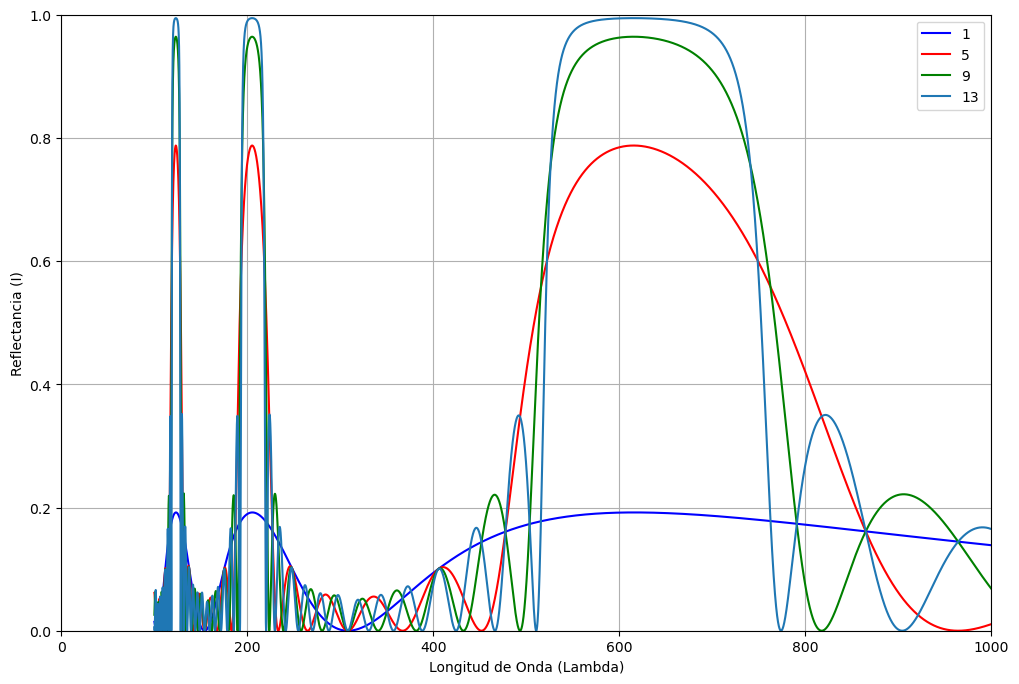

In [10]:
#@title Ejemplo #1 (Kinoshita 2005)

ESPECTRO_ = np.arange(100,1000,0.05)
theta_1 = 0

INDICES_1, GROSOR_1= photonic_crystal_1D(1.6,0,1,0,154,96,1)
PELICULA_1 = multilayer_film(theta_1, "TE", ESPECTRO_, INDICES_1, GROSOR_1)

INDICES_5, GROSOR_5= photonic_crystal_1D(1.6,0,1,0,154,96,5)
PELICULA_5 = multilayer_film(theta_1, "TE", ESPECTRO_, INDICES_5, GROSOR_5)

INDICES_9, GROSOR_9= photonic_crystal_1D(1.6,0,1,0,154,96,9)
PELICULA_9 = multilayer_film(theta_1, "TE", ESPECTRO_, INDICES_9, GROSOR_9)

INDICES_13, GROSOR_13= photonic_crystal_1D(1.6,0,1,0,154,96,13)
PELICULA_13 = multilayer_film(theta_1, "TE", ESPECTRO_, INDICES_13, GROSOR_13)

Y_1 = 1 - np.abs(PELICULA_1[:,0,0])**2
Y_5 = 1 - np.abs(PELICULA_5[:,0,0])**2
Y_9 = 1 - np.abs(PELICULA_9[:,0,0])**2
Y_13 = 1 - np.abs(PELICULA_13[:,0,0])**2

plt.figure(figsize=(12, 8))
plt.plot(ESPECTRO_,Y_1, "b", label = "1")
plt.plot(ESPECTRO_,Y_5, "r", label = "5")
plt.plot(ESPECTRO_,Y_9, "g", label = "9")
plt.plot(ESPECTRO_,Y_13, label = "13")

plt.xlabel("Longitud de Onda (Lambda)")
plt.ylabel("Reflectancia (I)")
plt.grid()
plt.legend()

plt.xlim(0, 1000)
plt.ylim(0, 1)

plt.show()

*Figura original (kinoshita 2005)*

![Kinoshita 2005](https://github.com/ELS4nchez/Imagenes/blob/main/Captura%20de%20pantalla%202023-11-28%20100434.png?raw=true)

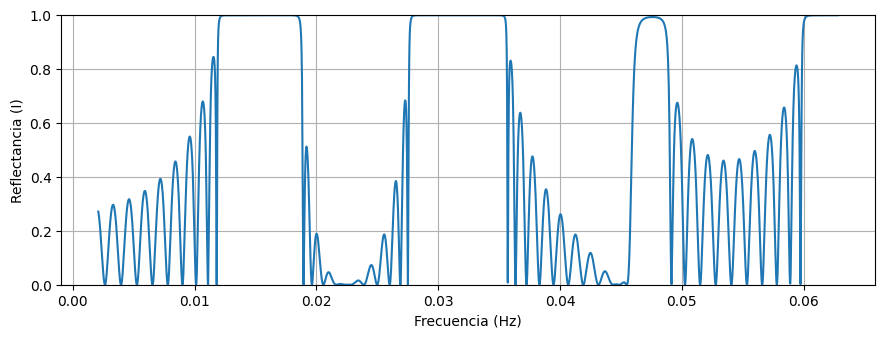

In [20]:
#@title Ejemplo #2 (Fundamental of Photonics, Saleh, Ejemplo 7.1-8)

ESPECTROO_ = np.arange(100,3000,0.05)

INDICESS_EJ, GROSORR_EJ = photonic_crystal_1D_in_n0(1.5,0,3.5,0,40,40,21)
theta_1 = 0

PELICULAA_EJ = multilayer_film(theta_1, "TE", ESPECTROO_, INDICESS_EJ, GROSORR_EJ)

YY_EJ = (1 - np.abs(PELICULAA_EJ[:,0,0])**2)
FRECUENCIAS_ = (2 * np.pi) / (ESPECTROO_[:])

plt.figure(figsize=(10.5, 3.5))
plt.plot(FRECUENCIAS_,YY_EJ)

plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Reflectancia (I)")
plt.grid()

plt.ylim(0, 1)

plt.show()

*Figura original (Ejemplo 7.1-8)*

![Ejemplo 7.1-8](https://github.com/ELS4nchez/Imagenes/blob/main/Captura%20de%20pantalla%202023-11-28%20100601.png?raw=true)